##### Agnieszka Marciszewska

# Machine Learning
## Assigment 2
##### http://prac.im.pwr.edu.pl/~bdyda/sem2022zimowy/ml.phtml

In [1]:
import pickle
import gzip
import numpy as np
from matplotlib import pyplot as plt
import random

##### Download and prepare data

In [2]:
# %load mnist_loader.py
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


In [4]:
training_data, validation_data, test_data = load_data_wrapper()

In [7]:
num_of_input = 50000

train_d = list(training_data)
x_train = [train_d[i][0] for i in range(num_of_input)]
y_train = [train_d[i][1] for i in range(num_of_input)]

x_train=np.array(x_train)
x_train = x_train[:, :, 0]
x_train = x_train.T

y_train=np.array(y_train)
y_train = y_train[:, :, 0]
y_train=y_train.T

x_train = x_train[:,0:num_of_input]
y_train = y_train[:,0:num_of_input]

test_d = list(test_data)
x_test = [test_d[i][0] for i in range(10000)]
y_test = [test_d[i][1] for i in range(10000)]

x_test=np.array(x_test)
x_test = x_test[:, :, 0]
x_test = x_test.T

y_test=np.array(y_test)
y_test = np.reshape(y_test, (-1, 1))

#### Functions to forward and back propagation

In [9]:
def sigmoid(x):
    '''A sigmoid function which can be taken as activation function.
       Function return value 1/(1+np.exp(-x)) of input x, where value in (0,1).'''
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    ''' Function return derivative of sigmoid function.'''
    f_x = sigmoid(x)
    return f_x*(1-f_x)

def softmax(x):
    '''A softmax function which can be taken as activation function for last layer.'''
    exp = np.exp(x)
    return exp/np.sum(exp,axis=0)

#### Function with forward and back propagation scheme

In [54]:
def forward_propagation(W,X,num):
    ''' Function with forward propagation scheme.
        input:
            W - list with weights,
            X - set of inputs,
            num - number of hidden layers
        output:
            next_a - list with outputs for next layers 
            next_net - list with results of multiplication of matrix of weight (W) and matrix of values (X)
            next_X - list with values for layers with a bias
        '''
    next_X = []
    next_X.append(X)
    next_a = []
    next_net = []
    for i in range(num):
        _,n = X.shape
        X_i = np.vstack((np.ones((1,n)),X))
        net_i = W[i] @ X_i
        a_i = sigmoid(net_i)
        X = a_i
        next_a.append(a_i)
        next_net.append(net_i)    
        next_X.append(X_i)
        
    X = next_a[-1]
    _,n = X.shape
    X_last = np.vstack((np.ones((1,n)),X))
    net_last = W[-1] @ X_last
    a_last = softmax(net_last)
    next_a.append(a_last)
    next_net.append(net_last)    
    next_X.append(X_last)
    
    return next_a,next_net,next_X



In [11]:
def back_propagation(W, next_a, next_net, next_X, y, num, num_of_input, c=0.1):
    ''' Function with backward propagation scheme
        input:
            W - list with weights,
            next_a - list with outputs for next layers ,
            next_net - list with results of multiplication of matrix of weight (W) and matrix of values (X),
            next_X - list with values for layers with a bias,
            y - set of correct outputs,
            num - number of hidden layers
            num_of_input - number of inputs,
            c - earning rate 
        output:
            W - list with updated weights.
        '''
    delta_last = next_a[num]-y
    dW_last = 1 / num_of_input * delta_last @ next_X[num+1].T
    dX_last = 1 / num_of_input * W[num].T @ delta_last
    W[num] = W[num] - c * dW_last
    for i in range(num-1,-1,-1):
        da = dX_last[1:,:]
        delta = da * d_sigmoid(next_net[i])
        dW = delta @ next_X[i+1].T
        dX = 1 / num_of_input * W[i].T @ delta
        dX_last = dX
        W[i] = W[i] - c * dW
    
    return W

#### Functions to learn the neaural networks and show results

In [77]:
def learn(X,Y,layer,num_ep):
    ''' Function generates weights with random values and num_ep-times calls 
        functions forward_propagation and backward_propagation and updates weights.
    input:
        X - set of inputs,
        Y - set of outputs,
        layer - list with numbers of neurons in hidden layers
        num_ep - number of epochs
    output:
        W - list with updated weights for a model.
    '''
    #initialize weights
    W = []

    m, n = X.shape 
    k, _ = Y.shape 
    W.append(np.random.normal(0, 2/np.sqrt(m+1),(layer[0],m+1)))
    num = len(layer) #number of hidden layers, if there are more than 1, we add them in the loop
    for i in range(1,num):
            W.append(np.random.normal(0, 2/np.sqrt(layer[i]+1),(layer[i],layer[i-1]+1)))
    W.append(np.random.normal(0, 2/np.sqrt(layer[-1]+1),(k,layer[-1]+1)))
    
    #learning num_iter times   
    for i in range(num_ep):
        next_a,next_net,next_X = forward_propagation(W, X,num)
        W = back_propagation(W, next_a, next_net, next_X, Y, num, n)
        
        if i % 100 == 0:  #every 100 iterations we check the accuracy
            acc = get_number_of_same_a(next_a[-1],Y)
            if i == 0:
                print('Epoch: 1, accuracy: ',acc/n)
            else:
                print('Epoch:',i,', accuracy: ',acc/n)
    acc = get_number_of_same_a(next_a[-1],Y)
    print('Epoch:',num_ep,', accuracy: ',acc/n)
    return W

In [69]:
def predict(W, X):
    ''' The function return predict value for input values.
        input: 
            W - weights of learned model,
            X - set of inputs,
        output:
            predict_value - predict value for input values
    '''
    next_a, _, _ = forward_propagation(W,X,len(W)-1) # number of hidden layer = number of weights - 1
    predict_value = np.argmax(next_a[-1],axis = 0)
    return predict_value

def get_acc_test(W,X,Y):
    '''The function returns the accuracy of the model for a given set of test inputs.
       input: 
           W - weights of learned model,
           X - set of test inputs,
       output:
           accuracy - accuracy of the model
    '''
    predict_values = predict(W, X)
    Y = np.argmax(Y,axis=0)
    accuracy = np.sum(predict_values == Y)/len(Y)
    print("The accuracy of the model for a given set of test inputs: ",accuracy)


def compare(num_of_input_X,W):
    '''The function prints the predicted value and correct one.
       input: 
           W - weights of learned model,
           num_of_input_X - number of set of inputs (number of the image in set),
    '''
    X =  x_test[:,num_of_input_X]
    X = np.reshape(X, (-1, 1))
    predict_value = predict(W,X)
    value = y_test[num_of_input_X]
    print('Correct value: ',int(value))
    print('Predicted value: ',int(predict_value))
    X_image = X.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(X_image, interpolation='nearest')
    plt.show()
    
def get_number_of_same_a(a,Y):
    '''The function returns the number of correct predicted values.
       input: 
           a - predicted values ,
           Y - correct values,
       output:
           num - number of correct predicted values 
    '''
    predict_value = np.argmax(a,axis = 0)
    y = np.argmax(Y,axis = 0)
    num = np.sum(predict_value == y)
    return num

#### Examples:

In [79]:
model1 = learn(x_train,y_train,[64],1000)

Epoch: 1, accuracy:  0.09286
Epoch: 100 , accuracy:  0.76796
Epoch: 200 , accuracy:  0.83116
Epoch: 300 , accuracy:  0.85496
Epoch: 400 , accuracy:  0.86796
Epoch: 500 , accuracy:  0.87634
Epoch: 600 , accuracy:  0.88212
Epoch: 700 , accuracy:  0.8864
Epoch: 800 , accuracy:  0.88982
Epoch: 900 , accuracy:  0.89322
Epoch: 1000 , accuracy:  0.89576


In [82]:
get_acc_test(model1,x_train,y_train)

The accuracy of the model for a given set of test inputs:  0.89578


Correct value:  4
Predicted value:  4


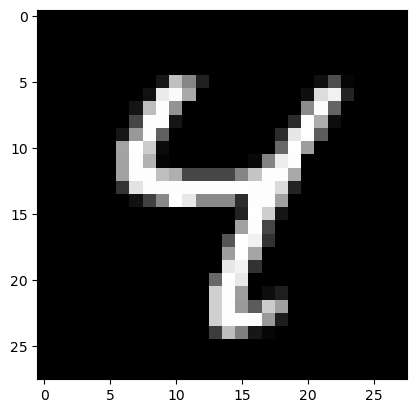

In [83]:
compare(6,model1)

Correct value:  6
Predicted value:  6


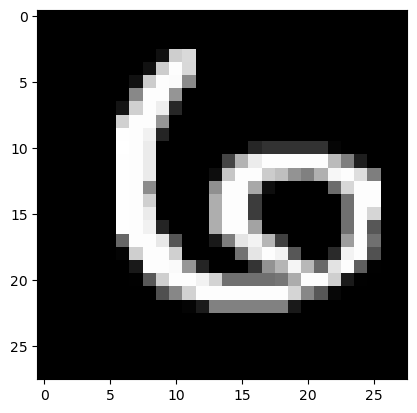

In [84]:
compare(54,model1)